In [299]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as pl
import torch.nn.functional as F
import torchvision.models as models

In [300]:
from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid

In [301]:
from Models.CNN_model import CNN
from Models.VGG19_model import VGG19

In [302]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [303]:
cnn = CNN()
cnn.load_state_dict(torch.load('../assets/cnn_model.pth', map_location = device))
cnn.eval()

CNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=12544, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [304]:
original_vgg19_model = models.vgg19(weights = 'VGG19_Weights.DEFAULT')
vgg = VGG19(original_vgg19_model)
vgg.load_state_dict(torch.load('../assets/vgg19_transfer.pth', map_location = device))
vgg.eval()

VGG19(
  (original_vgg19_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

In [305]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.1855, 0.1855, 0.1855], std = [0.2003, 0.2003, 0.2004])
])

In [306]:
def prepare_image(image_path: str) -> torch.Tensor:
  image = Image.open(image_path)
  image = image.convert('RGB')
  image = image.resize((224, 224))

  pl.figure(figsize = (6, 6))
  pl.imshow(image)
  pl.axis('off')
  pl.show()

  image = image_transform(image)
  image = image.unsqueeze(0)
  image = image.to(device)

  return image

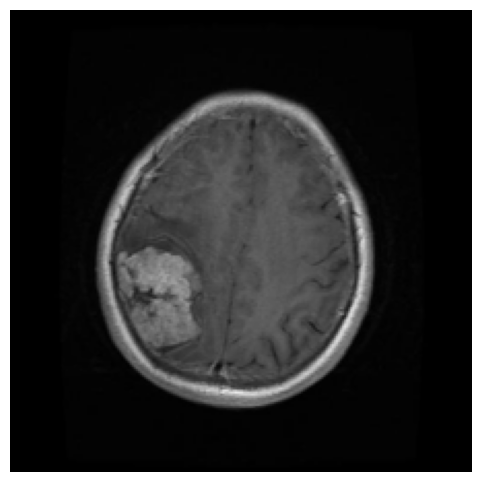

In [307]:
image = prepare_image('meningioma.jpg')

In [308]:
def get_conv_layers(model):
  convolution_layers = []

  for child in model.children():
    if isinstance(child, nn.Sequential):
      for layer in child:
        if isinstance(layer, nn.Conv2d):
          convolution_layers.append(layer)

  return convolution_layers

In [309]:
def visualize_conv_layers(model, image: torch.Tensor, layer: int, neuron: int):
  layers = get_conv_layers(model)
  outputs = [image := layer(image) for layer in layers]
  assert layer < len(outputs)

  layer_output = outputs[layer] # [1, 16, 224, 224] - 16 neurons
  layer_output = layer_output.squeeze(0) # Change the size to [16, 224, 224]
  layer_output = layer_output.detach().numpy()
  
  pl.figure(figsize = (30, 30))
  pl.imshow(layer_output[neuron].astype(np.uint8) * 255, cmap = 'gray')
  pl.axis('off')
  pl.show()

  # f, ax = pl.subplots(4, 4, figsize = (30, 30))
  # pl.rcParams.update({'font.size': 17})
  # pl.tight_layout()

  # neuron_ix = 0
  # for row in ax:
  #   for col in row:
  #     col.imshow(layer_output[neuron_ix].astype(np.uint8) * 255, cmap = 'gray')
  #     col.set_title(f'Wyjście z neuronu #{neuron_ix + 1}')
  #     col.axis('off')
  #     neuron_ix += 1

  return layer_output[neuron]

In [310]:
def get_activation(image: np.ndarray):
  output = F.relu(torch.Tensor(image))
  output = output.detach().numpy()

  pl.figure(figsize = (30, 30))
  pl.imshow(output.astype(np.uint8) * 255, cmap = 'gray')
  pl.axis('off')
  pl.show()

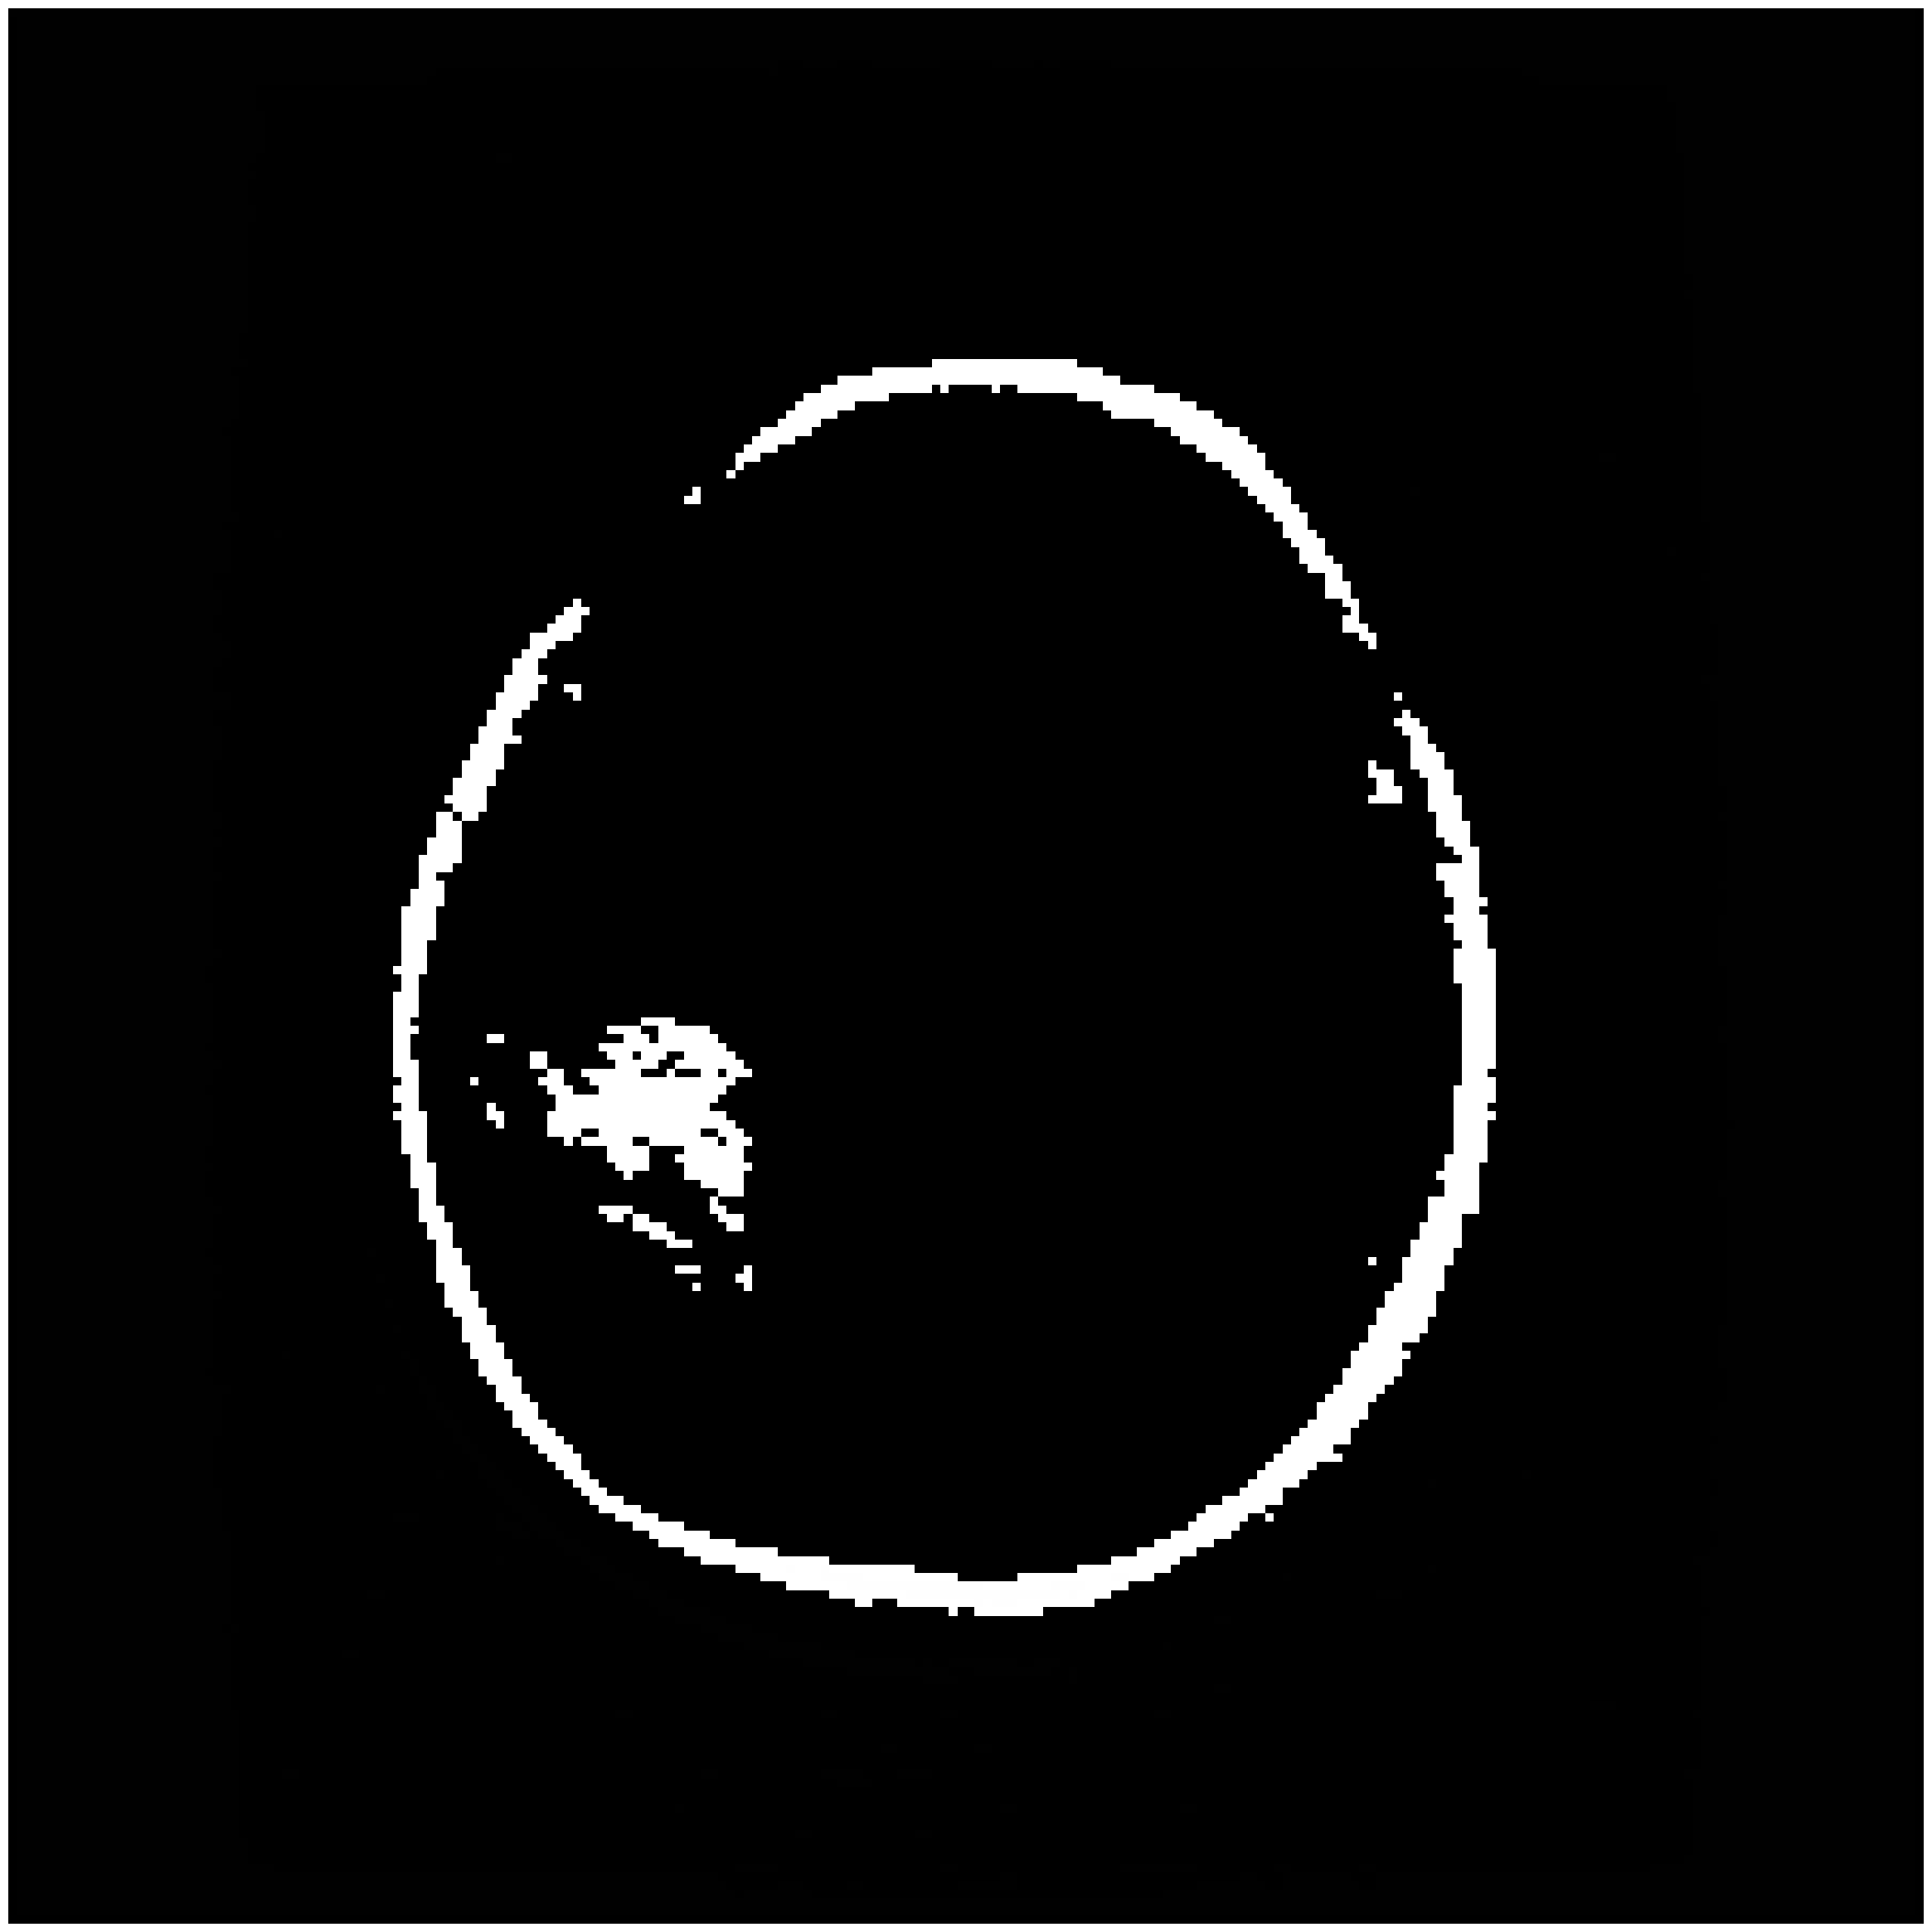

In [311]:
output = visualize_conv_layers(cnn, image, 0, 0)

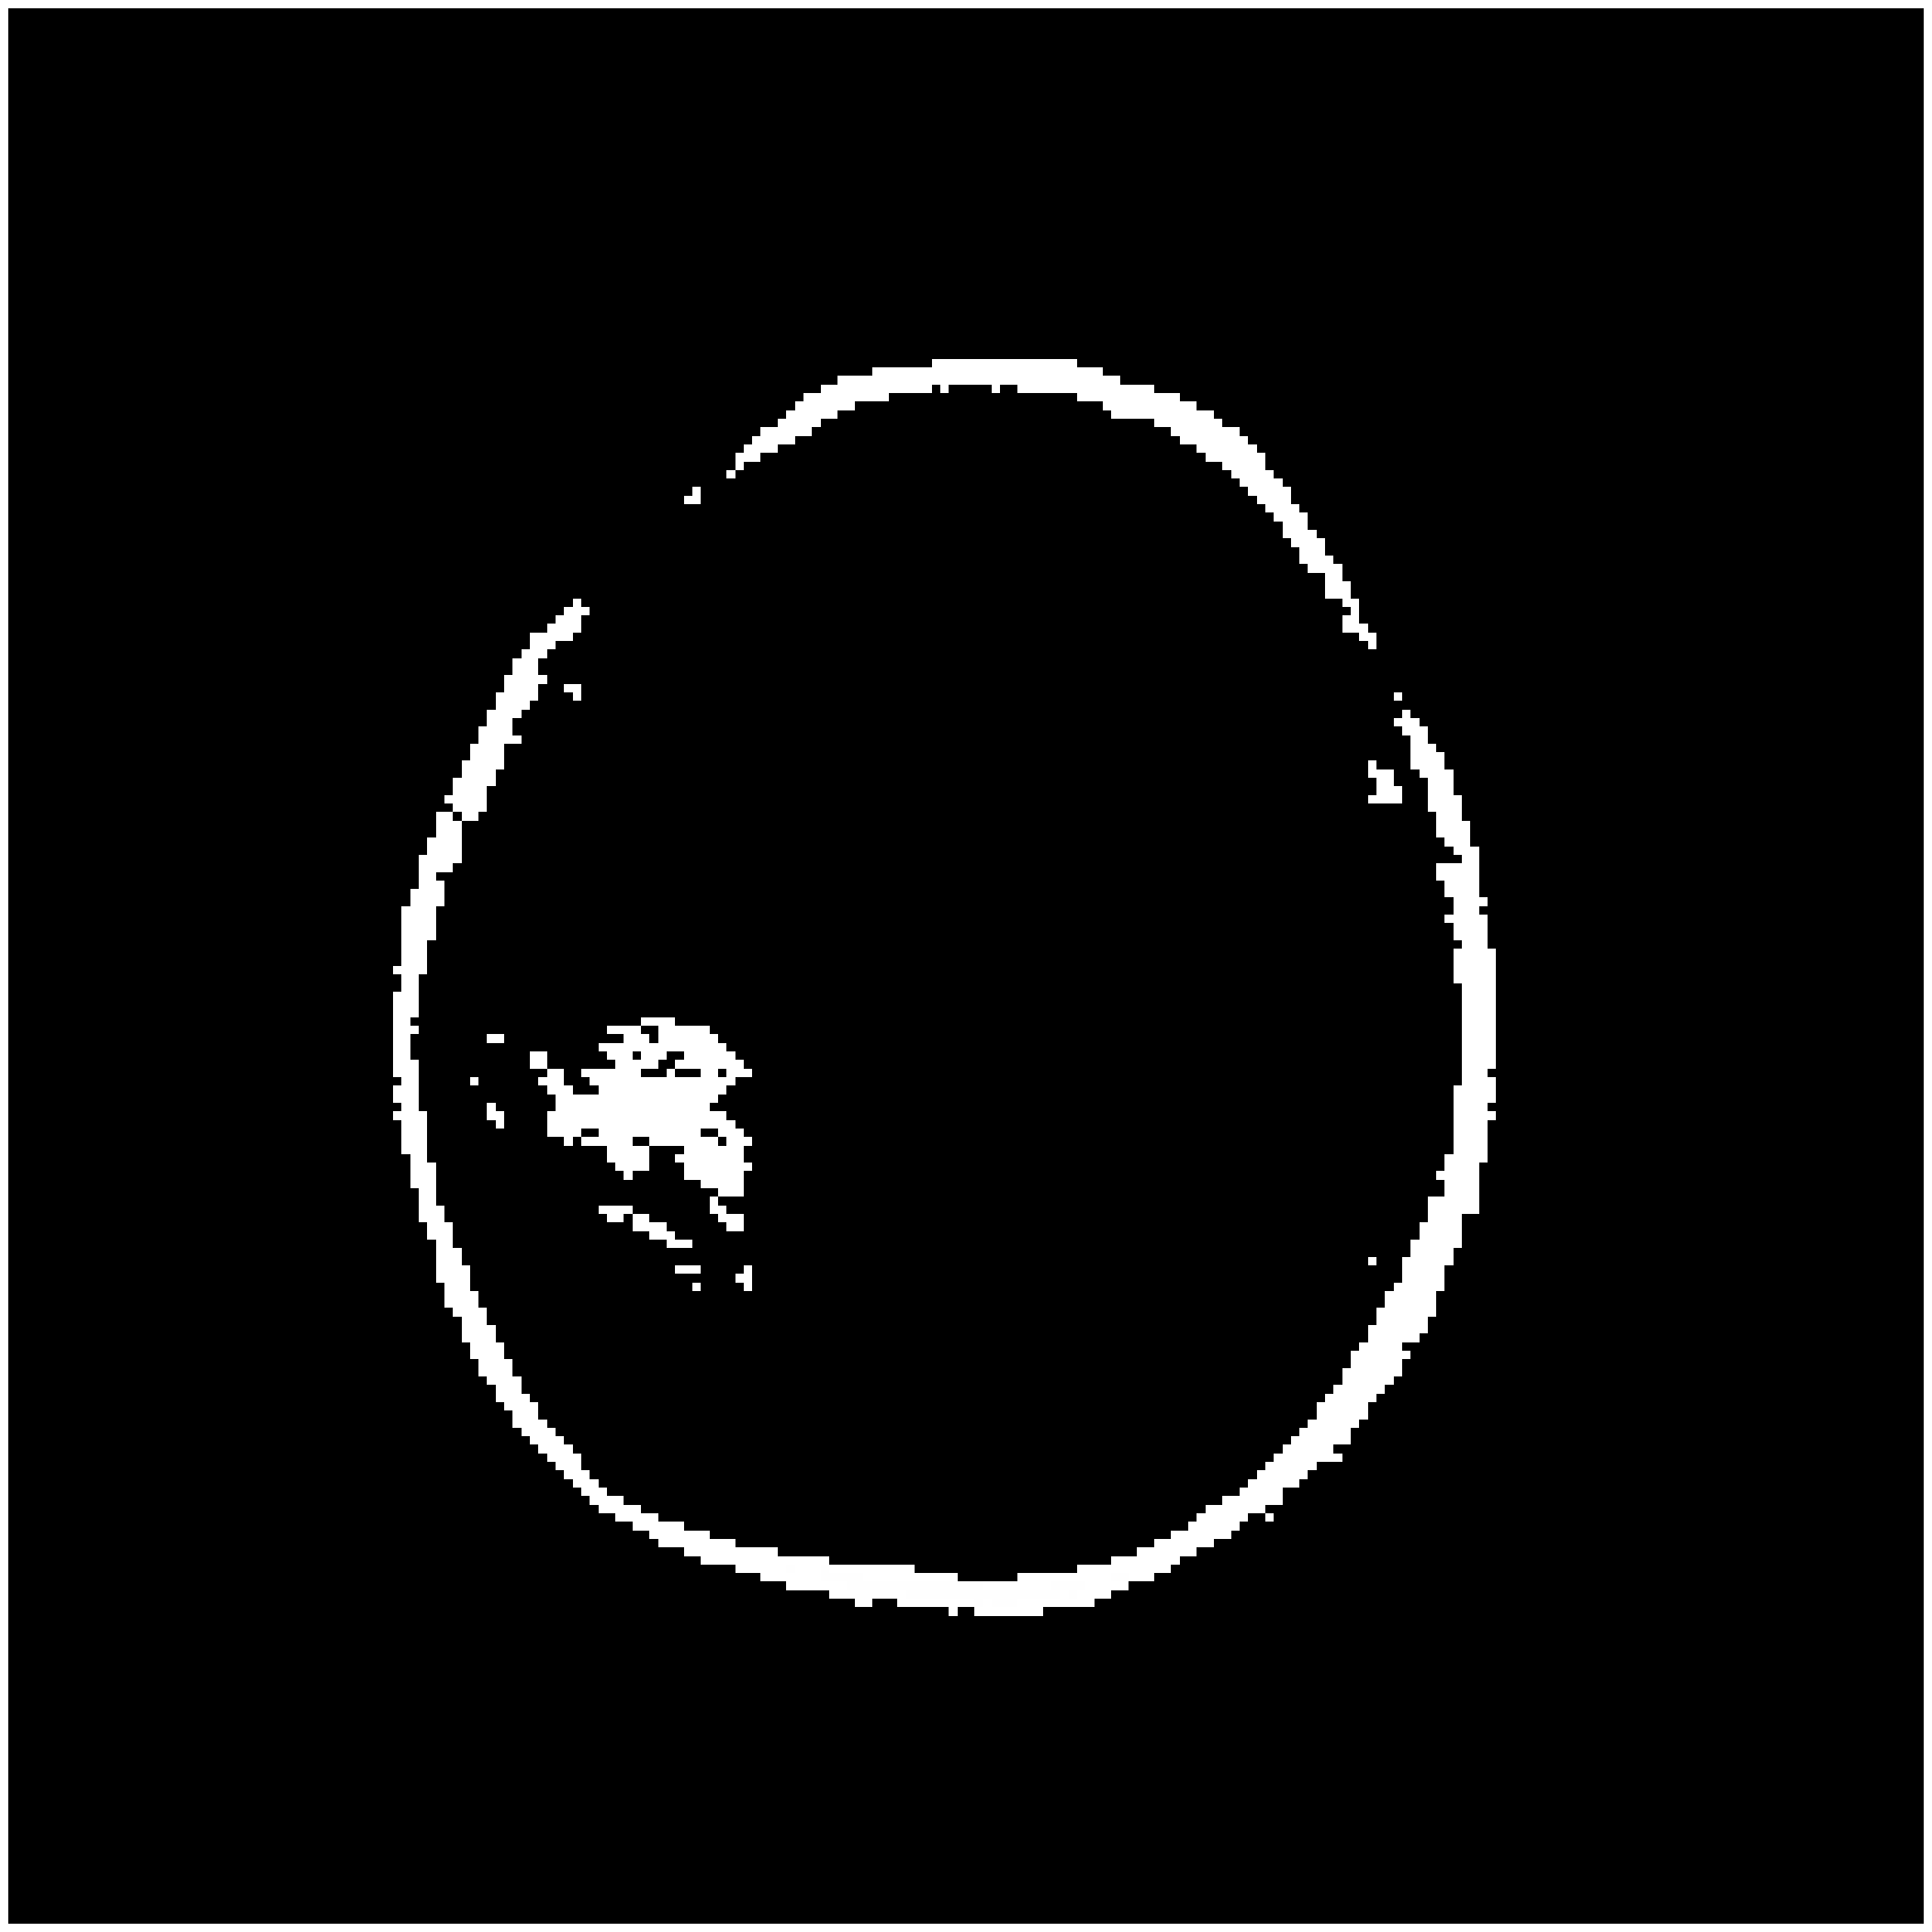

In [312]:
get_activation(output)

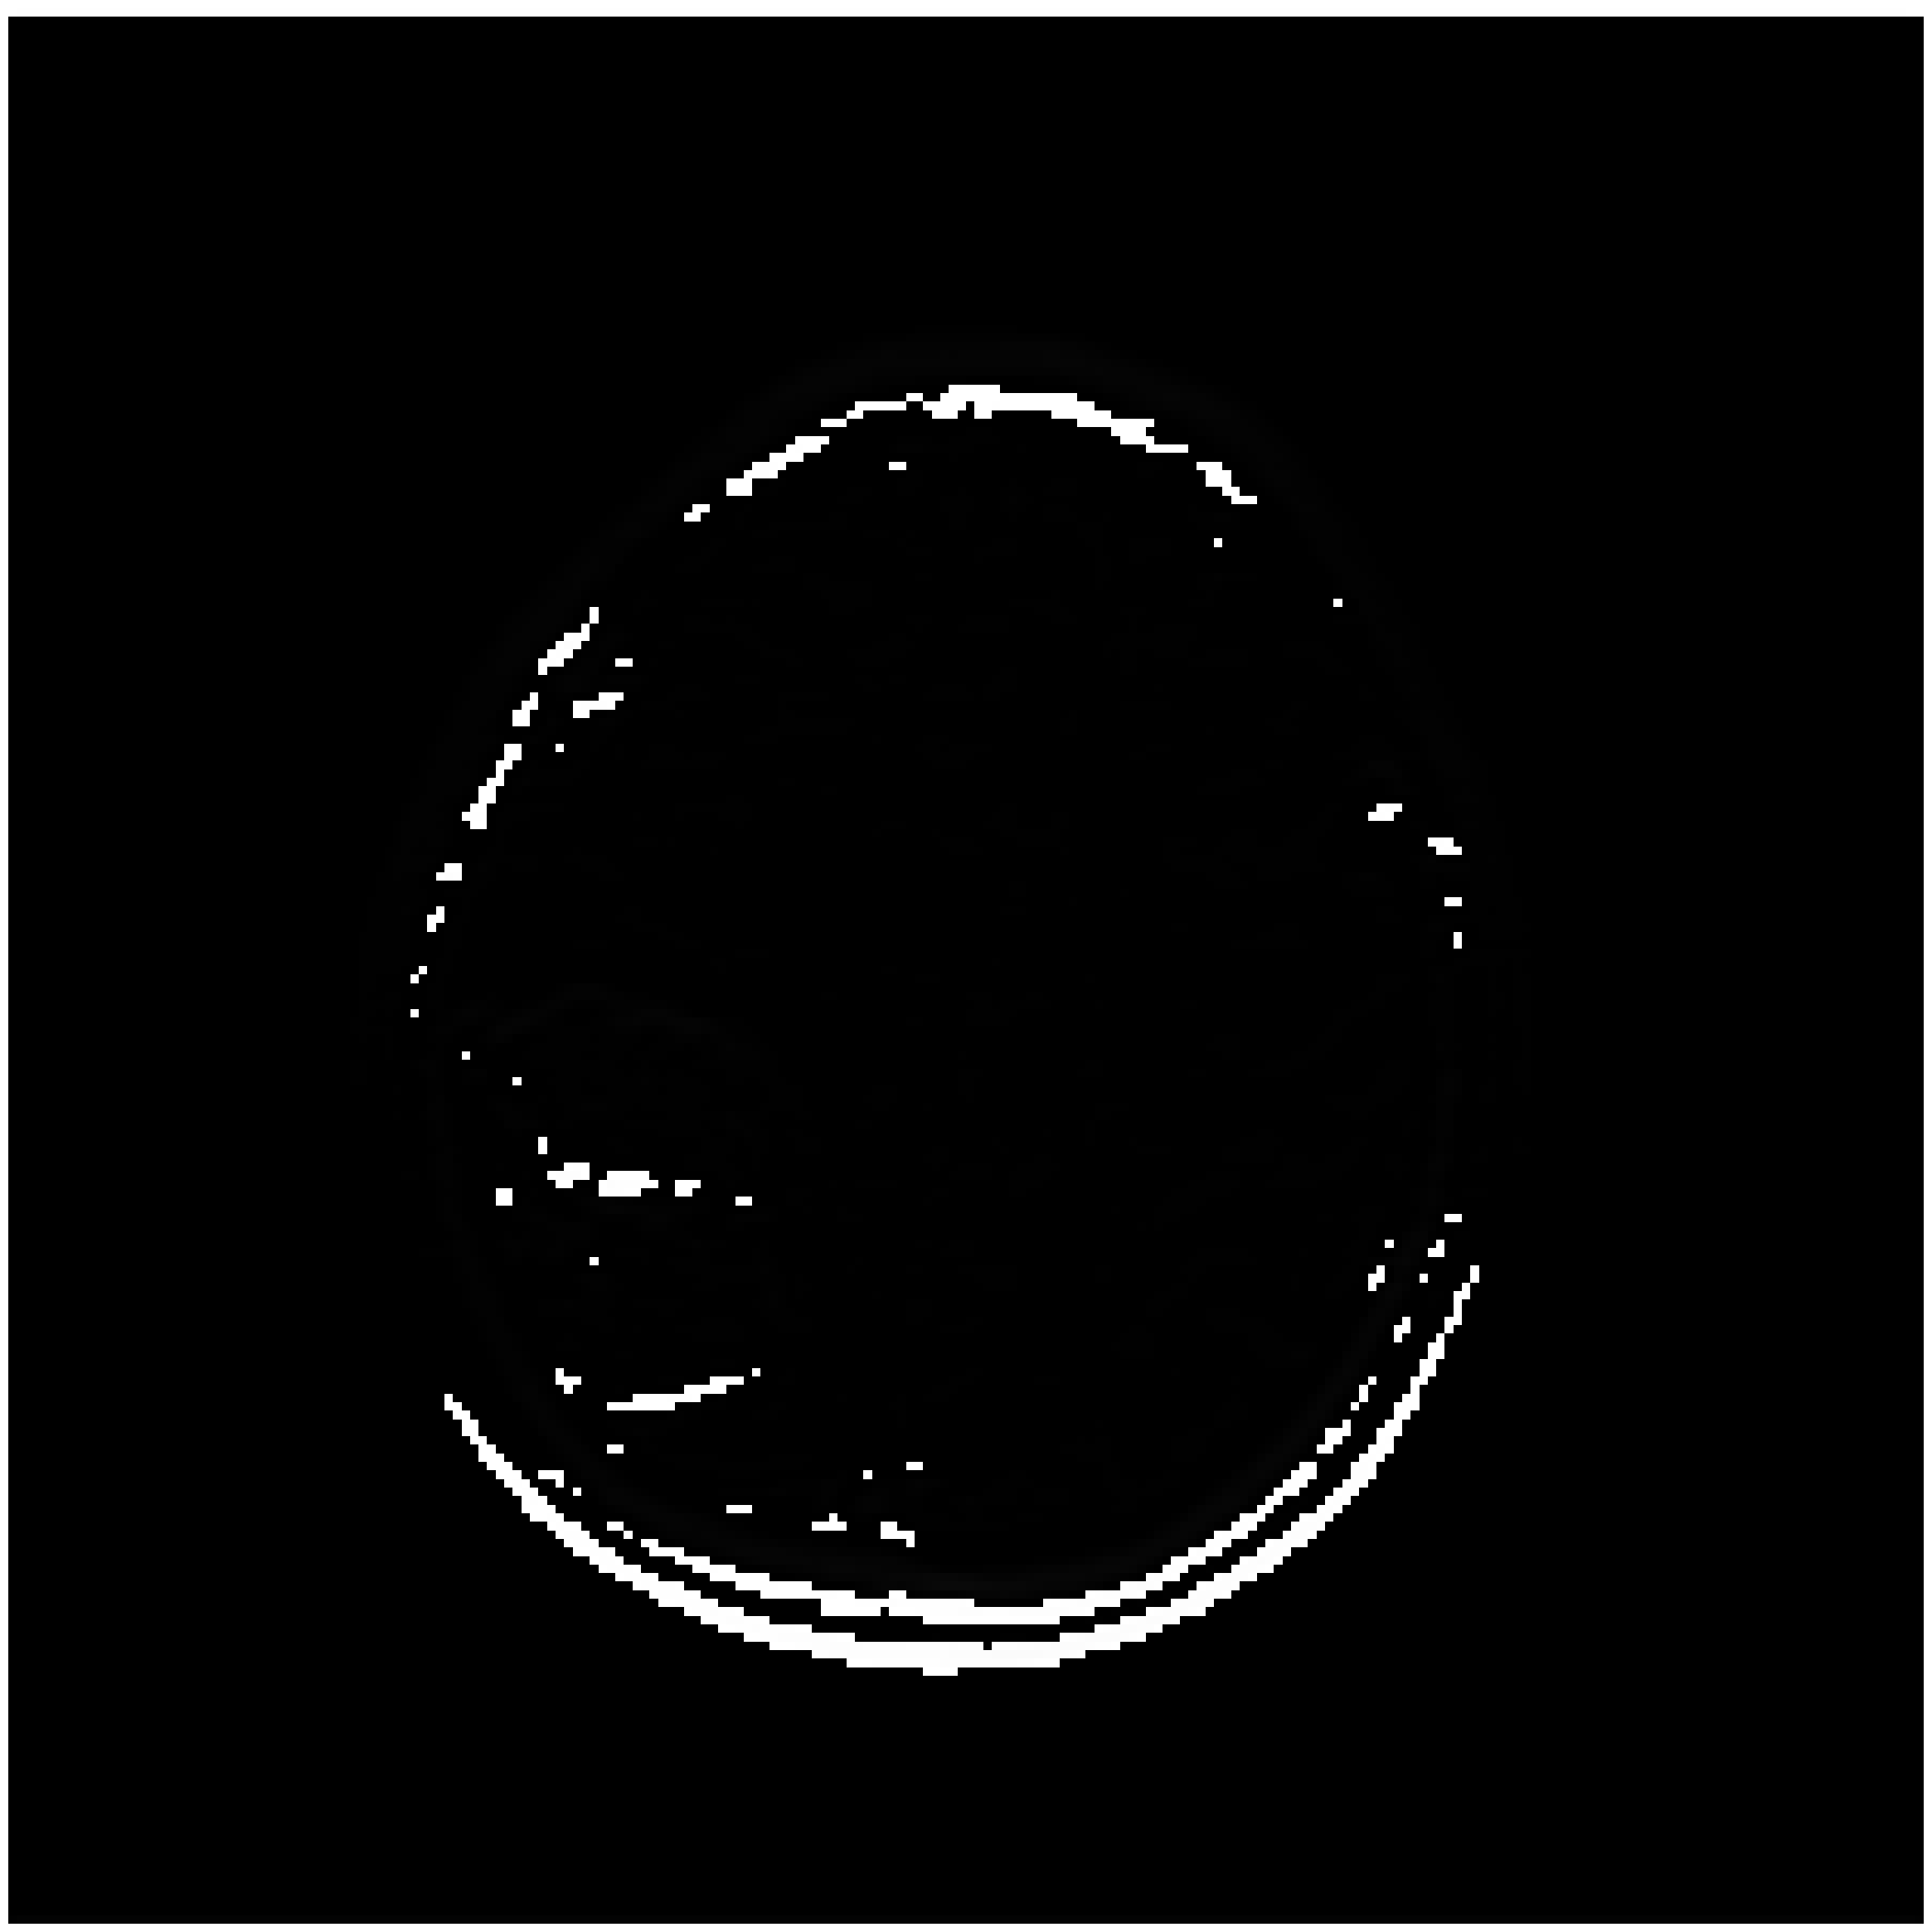

In [313]:
output = visualize_conv_layers(cnn, image, 1, 12)

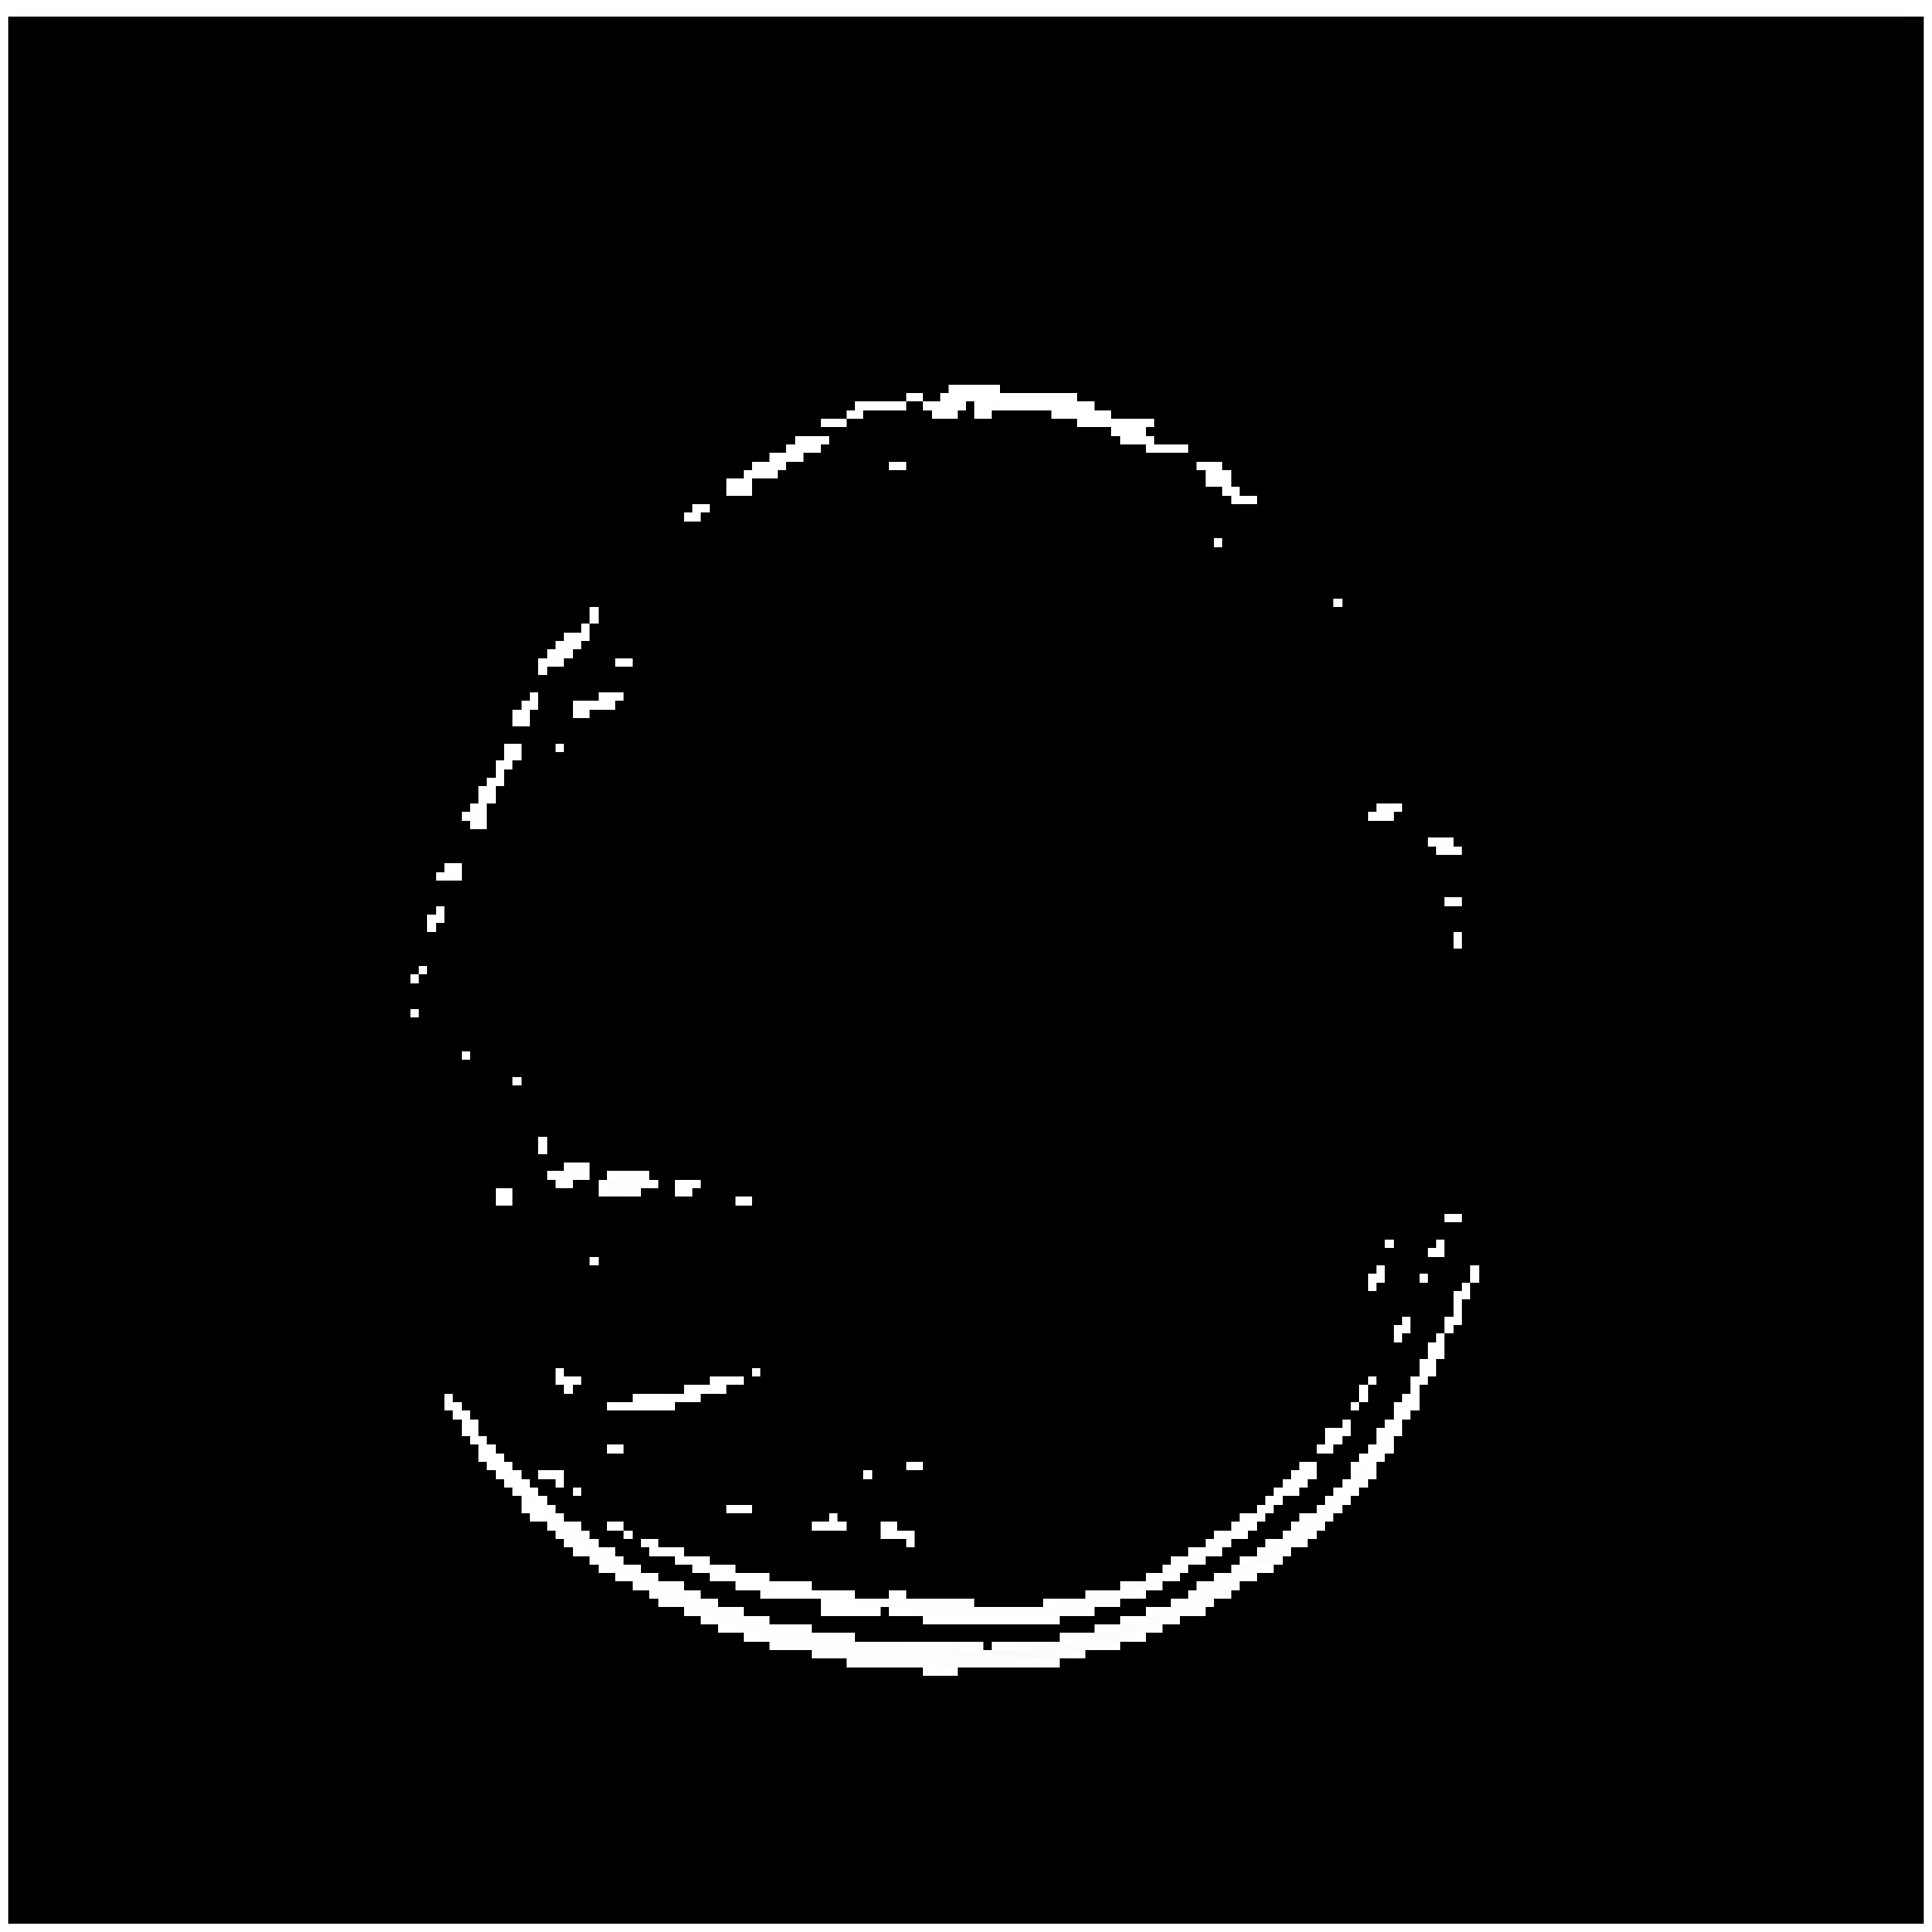

In [314]:
get_activation(output)

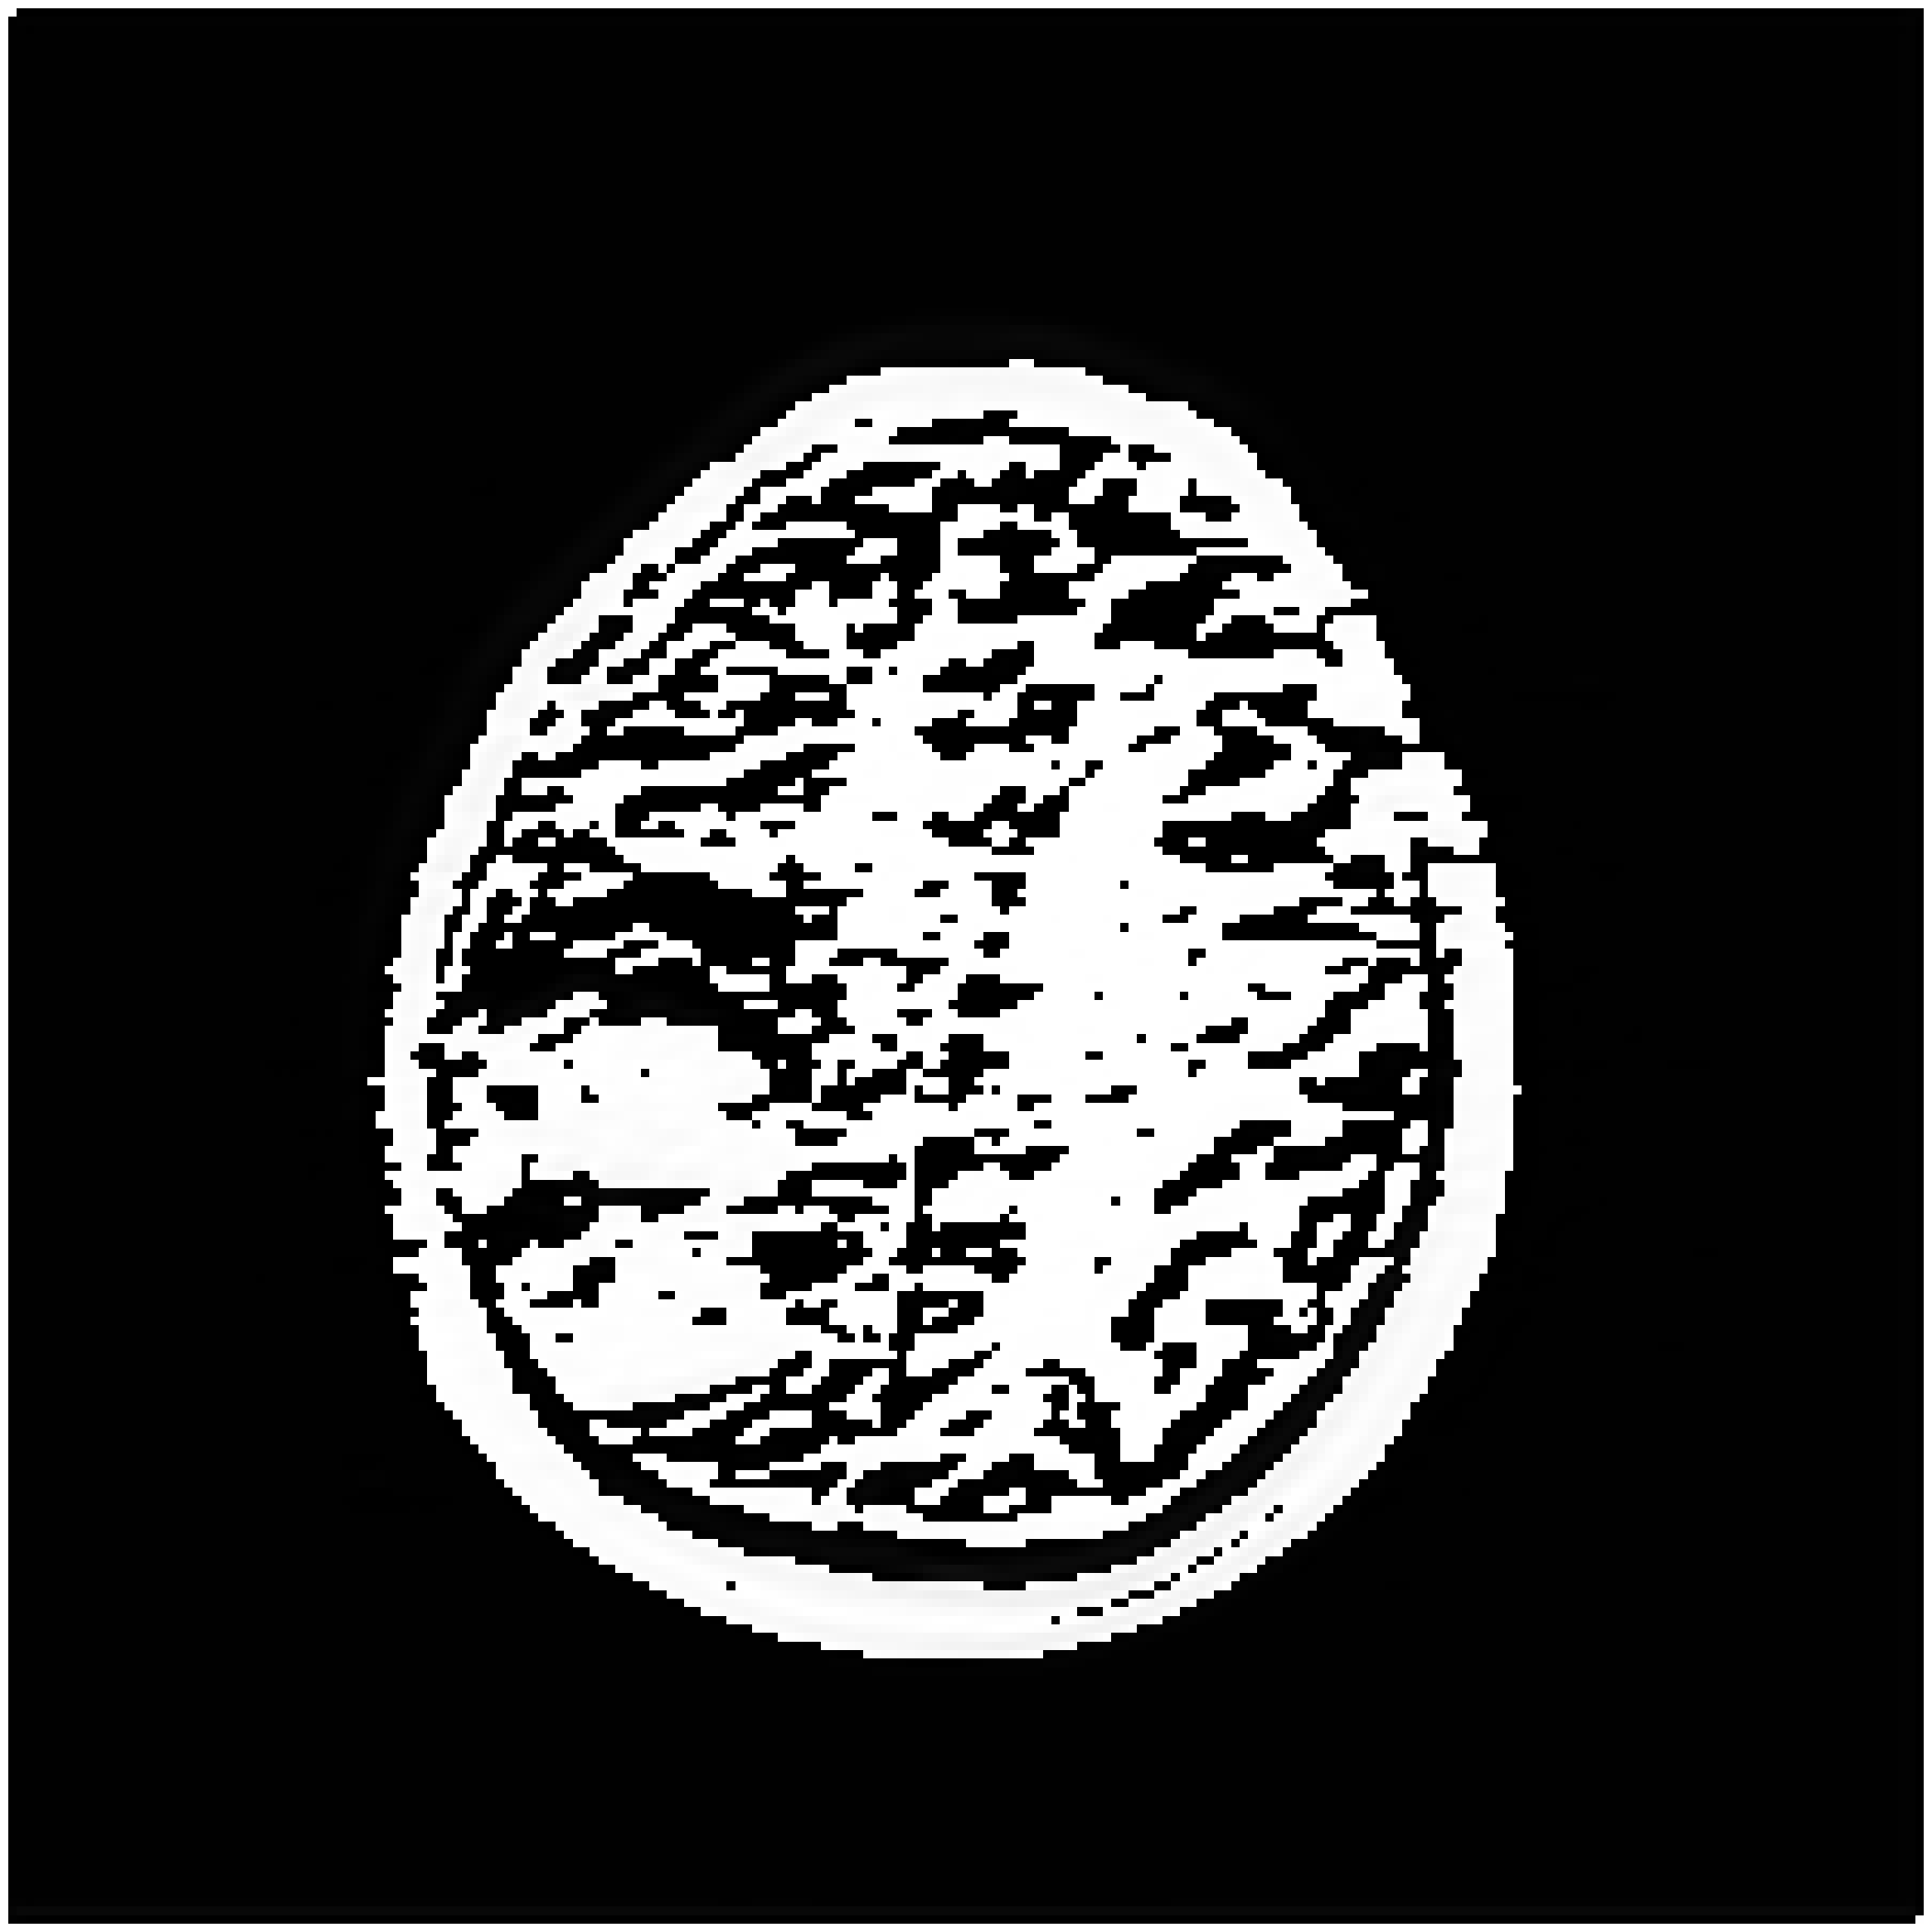

In [315]:
output = visualize_conv_layers(cnn, image, 2, 12)

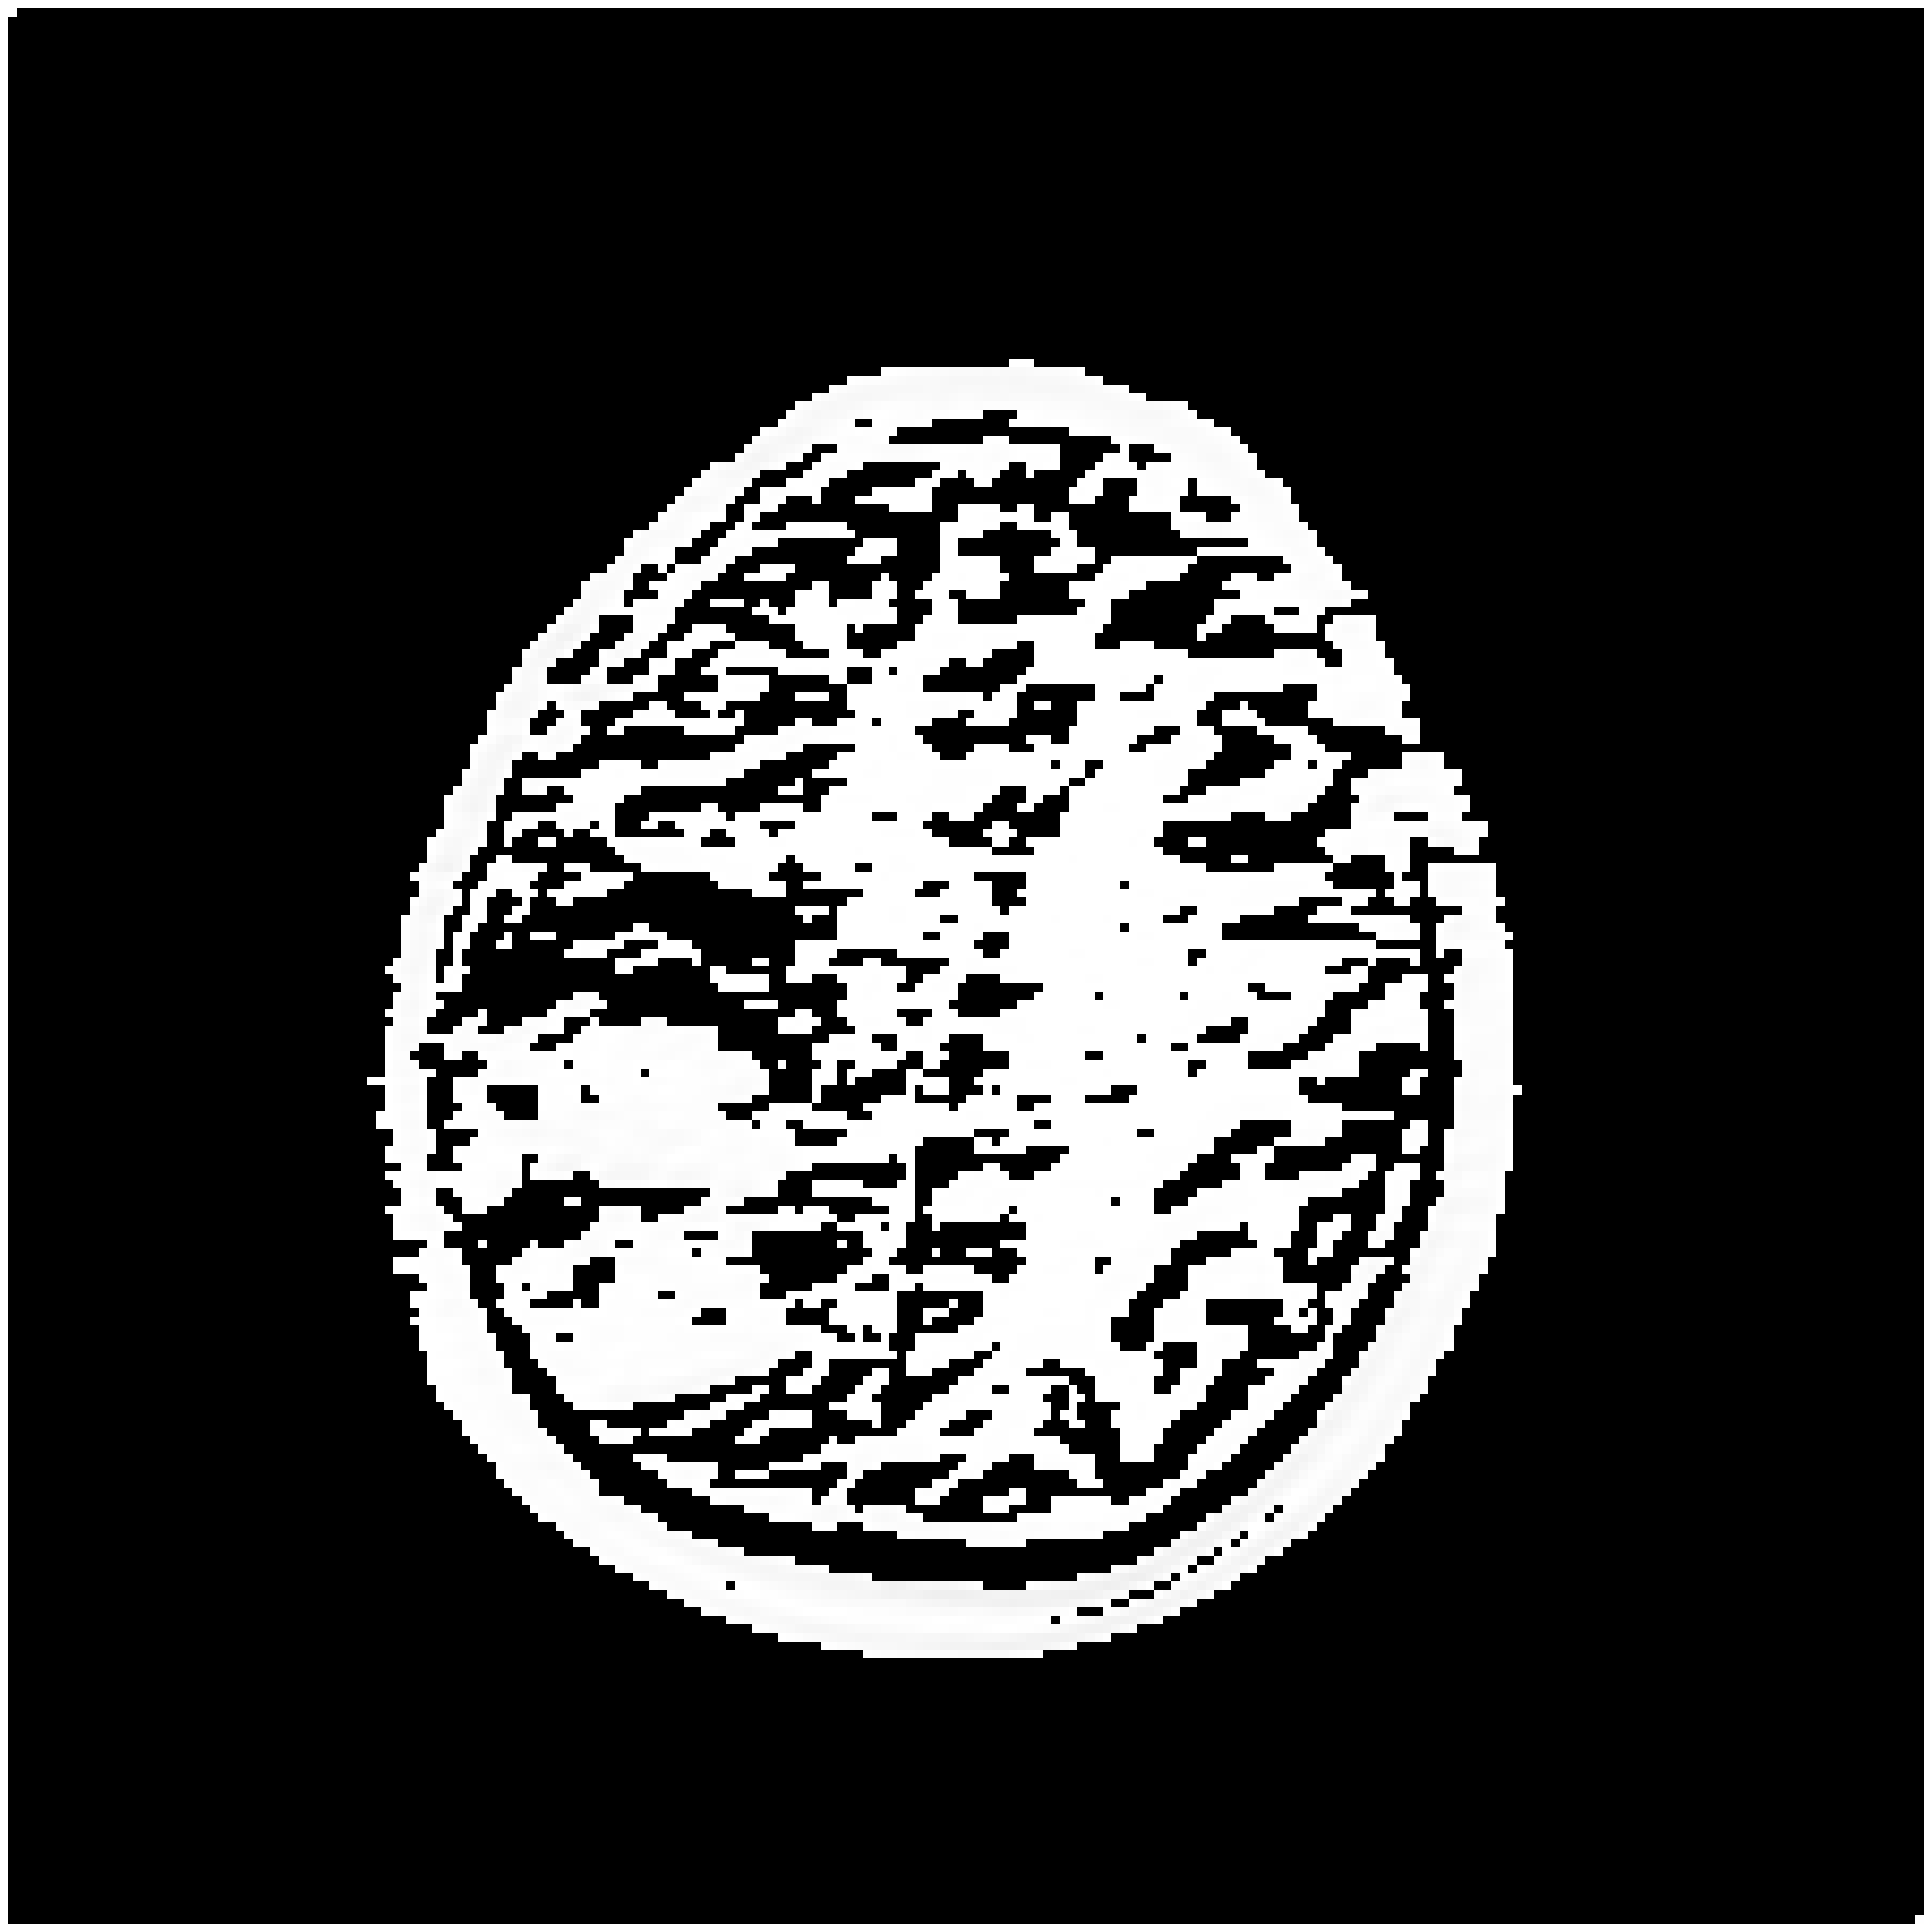

In [316]:
get_activation(output)

In [317]:
def visualize_filters_in_layer(model, layer: int, rgb: bool):
  assert isinstance(model.features[layer], nn.Conv2d)

  kernels = model.features[layer].weight.detach().clone()

  if not rgb:
    n, c, w, h = kernels.shape
    kernels = kernels.view(n * c, -1, w, h)

  kernels -= kernels.min()
  kernels /= kernels.max()
  grid = make_grid(kernels, nrow = 5)

  pl.figure(figsize = (40, 40))
  pl.imshow(grid.numpy().transpose((1, 2, 0)))
  pl.axis('off')

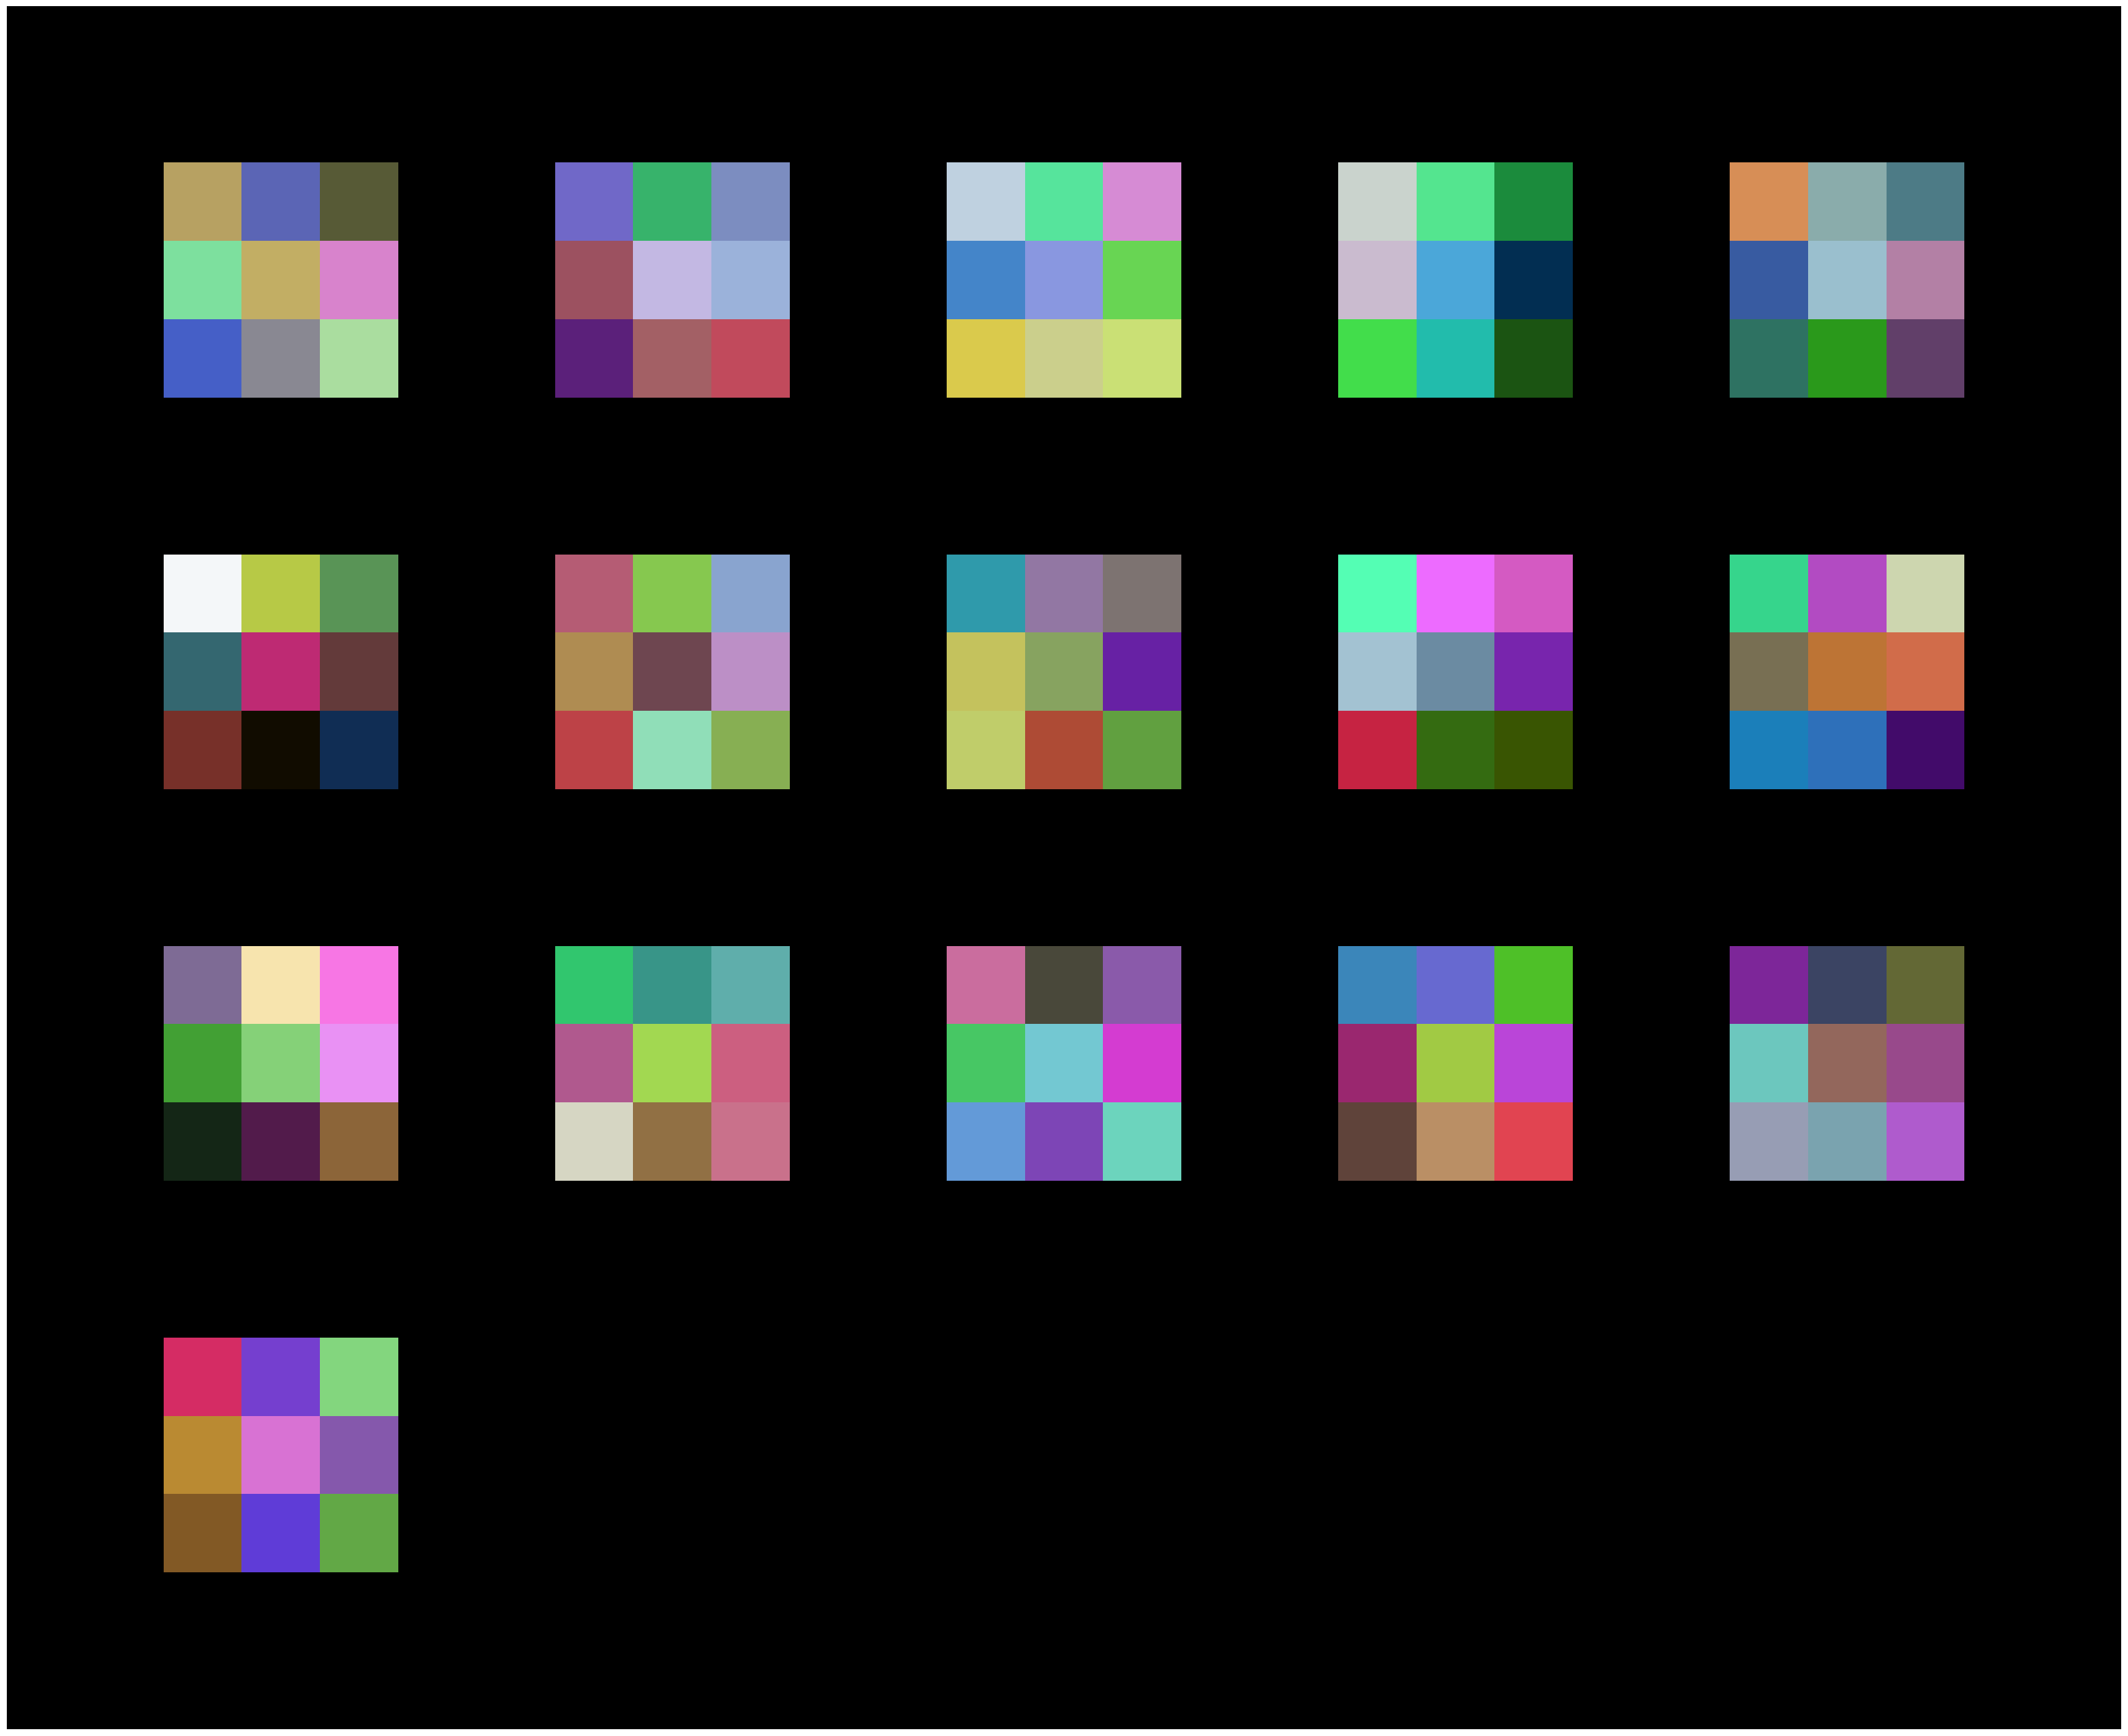

In [318]:
visualize_filters_in_layer(cnn, 0, True)

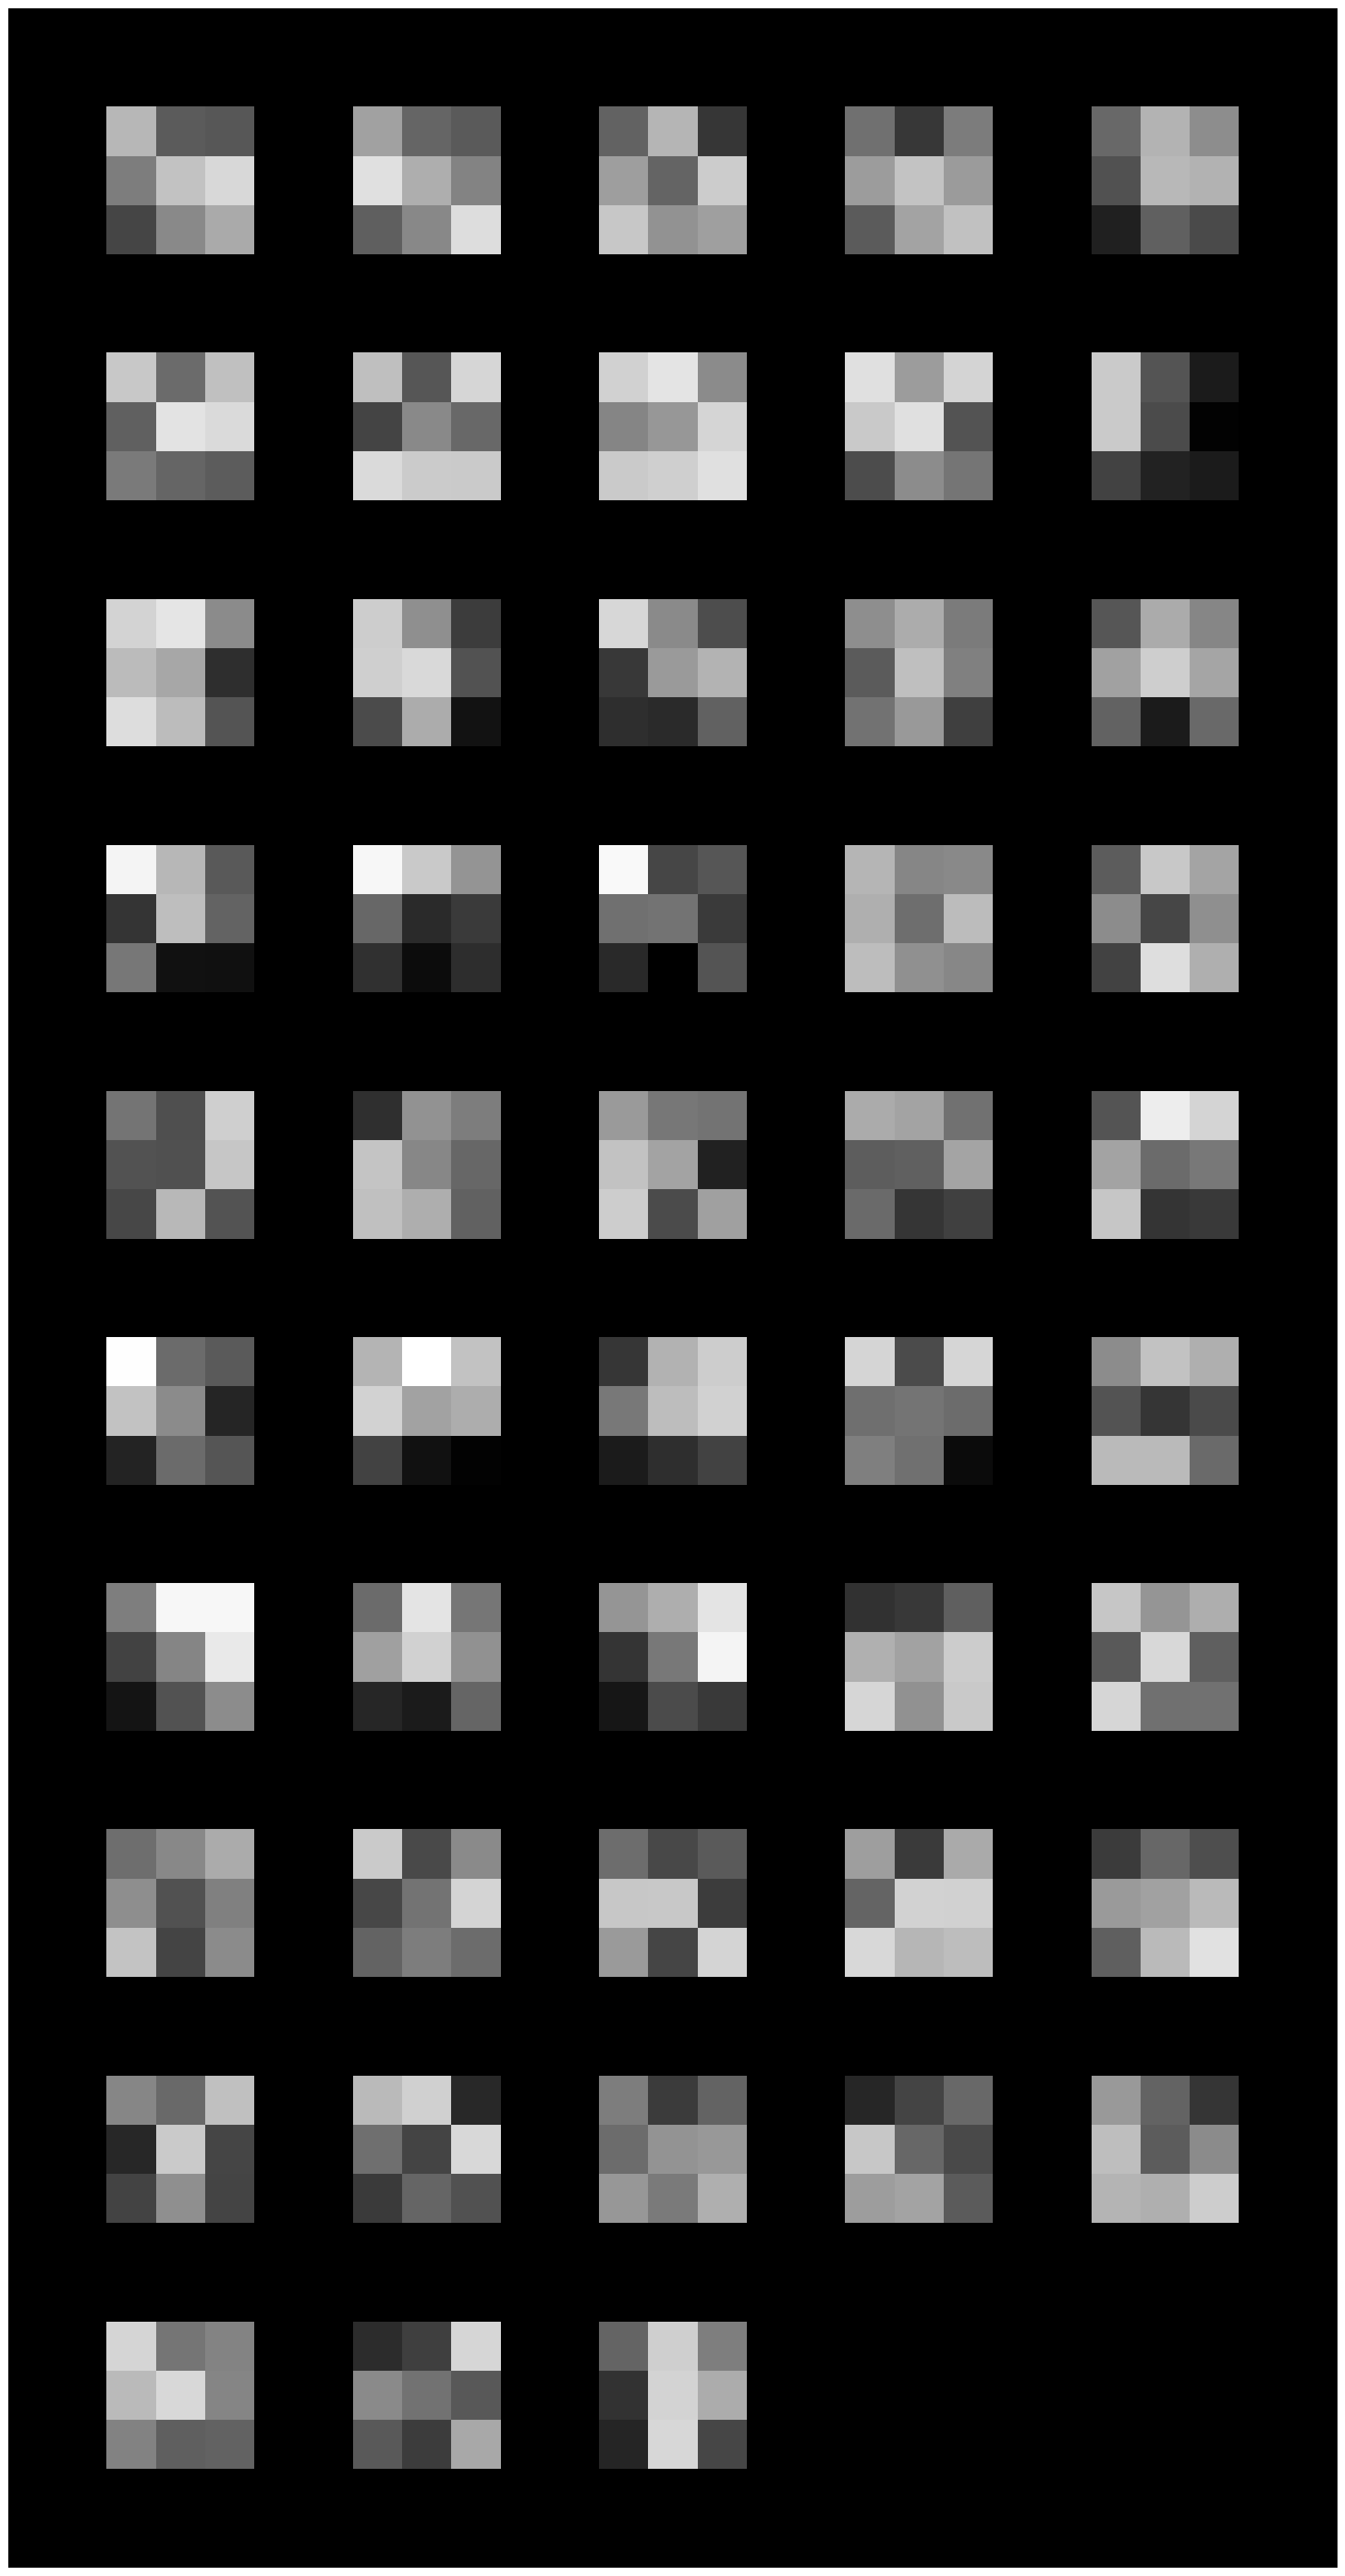

In [319]:
visualize_filters_in_layer(cnn, 0, False)